# Household Data Analysis

this Notebook analyzes and aggregates energy usage data from households

In [29]:
import pandas as pd
import glob
import os
import numpy as np

# Load all household data files into a dictionary
def load_household_data():
    # Get all CSV files from household_data directory
    csv_files = glob.glob("../../../../data/household_data/*.csv")
    
    household_dict = {}
    
    for file_path in csv_files:
        # Extract user ID from filename
        filename = os.path.basename(file_path)
        user_id = filename.replace('user_data_', '').replace('.csv', '')
        
        # Load CSV and store in dictionary
        df = pd.read_csv(file_path)
        household_dict[user_id] = df
    
    print(f"Loaded {len(household_dict)} household datasets")
    return household_dict

# Load the household data
household_data = load_household_data()

Loaded 101 household datasets


In [30]:
# Display basic information about household data
print(f"Number of households: {len(household_data)}")
print(f"Household IDs: {list(household_data.keys())[:10]}...")

# Show structure of first household
first_household = list(household_data.keys())[0]
first_df = household_data[first_household]

print(f"\nSample household: {first_household}")
print(f"Shape: {first_df.shape}")
print(f"Columns: {list(first_df.columns)}")
print("\nFirst few rows:")
display(first_df.head())

Number of households: 101
Household IDs: ['27665', '35467', '9774', '37728', '10625', '47755', '26801', '62262', '62464', '73025']...

Sample household: 27665
Shape: (35140, 3)
Columns: ['datetime', 'value', 'status']

First few rows:


,datetime,value,status
0,2023-11-01 00:15:00,0.112,W
1,2023-11-01 00:30:00,0.108,W
2,2023-11-01 00:45:00,0.118,W
3,2023-11-01 01:00:00,0.137,W
4,2023-11-01 01:15:00,0.161,W


In [4]:
# Calculate total energy usage for each household
print("Total Energy Usage by Household:")
print("=" * 40)

household_totals = []

for user_id, df in household_data.items():
        
    # Look for energy/usage column
    energy_col = df["value"]
    total_usage = energy_col.sum()/4
    
    household_totals.append(total_usage)
    
    print("User " + user_id + " total energy usage: " + str(total_usage) + "kWh")

print("=" * 40)

average_consumption = np.mean(household_totals)
print(f"Average total household energy consumption: {average_consumption:.2f} kWh")

Total Energy Usage by Household:
User 27665 total energy usage: 2186.01825kWh
User 35467 total energy usage: 2938.4805000000006kWh
User 9774 total energy usage: 737.0307499999999kWh
User 37728 total energy usage: 3317.5702499999998kWh
User 10625 total energy usage: 3077.27675kWh
User 47755 total energy usage: 3827.2445000000002kWh
User 26801 total energy usage: 4390.829749999999kWh
User 62262 total energy usage: 3494.3647499999997kWh
User 62464 total energy usage: 5945.384249999999kWh
User 73025 total energy usage: 6301.874500000001kWh
User 16681 total energy usage: 1414.3627500000002kWh
User 81516 total energy usage: 4671.838kWh
User 68413 total energy usage: 4142.735000000001kWh
User 57393 total energy usage: 3063.2597499999997kWh
User 0.43 total energy usage: 3583.10375kWh
User 63368 total energy usage: 2766.72825kWh
User 35729 total energy usage: 3275.6415kWh
User 55036 total energy usage: 3658.159kWh
User 16948 total energy usage: 3538.8425000000007kWh
User 31475 total energy usag

# Synthetic User

Create synthetic user using averages from all households

In [31]:
# Create synthetic average household
hourly_dfs = []

for user_id, df in household_data.items():
    # Convert timestamp to datetime and set as index
    df_copy = df.copy()
    df_copy['datetime'] = pd.to_datetime(df_copy['datetime'])
    df_copy.set_index('datetime', inplace=True)
    
    # Convert 15-minute increments to kWh and resample to hourly totals
    df_copy['value'] = df_copy['value'] / 4  # Convert from 15-min to kWh
    hourly_df = df_copy['value'].resample('H').sum()
    hourly_dfs.append(hourly_df)

# Concatenate all hourly data and calculate mean and confidence intervals
all_hourly = pd.concat(hourly_dfs, axis=1)
synthetic_user = pd.DataFrame()
synthetic_user['value'] = all_hourly.mean(axis=1)
synthetic_user['ci_lower'] = all_hourly.quantile(0.25, axis=1)  # 25th percentile
synthetic_user['ci_upper'] = all_hourly.quantile(0.75, axis=1)  # 75th percentile

# drop last entry in df to remove irregularity
synthetic_user = synthetic_user.iloc[:-1]

print(f"Created synthetic user with {len(synthetic_user)} hourly data points")
print(f"Date range: {synthetic_user.index.min()} to {synthetic_user.index.max()}")
display(synthetic_user.head())
display(synthetic_user.tail())


Created synthetic user with 8784 hourly data points
Date range: 2023-11-01 00:00:00 to 2024-10-31 23:00:00


,value,ci_lower,ci_upper
datetime,,,
2023-11-01 00:00:00,0.171782,0.05150,0.20350
2023-11-01 01:00:00,0.219782,0.07150,0.26575
2023-11-01 02:00:00,0.229361,0.07375,0.22950
2023-11-01 03:00:00,0.211040,0.06200,0.21725
2023-11-01 04:00:00,0.193545,0.05800,0.21500


,value,ci_lower,ci_upper
datetime,,,
2024-10-31 19:00:00,0.391309,0.14725,0.50325
2024-10-31 20:00:00,0.325092,0.13500,0.41575
2024-10-31 21:00:00,0.301814,0.13325,0.39150
2024-10-31 22:00:00,0.268587,0.10750,0.30550
2024-10-31 23:00:00,0.218582,0.08750,0.28700


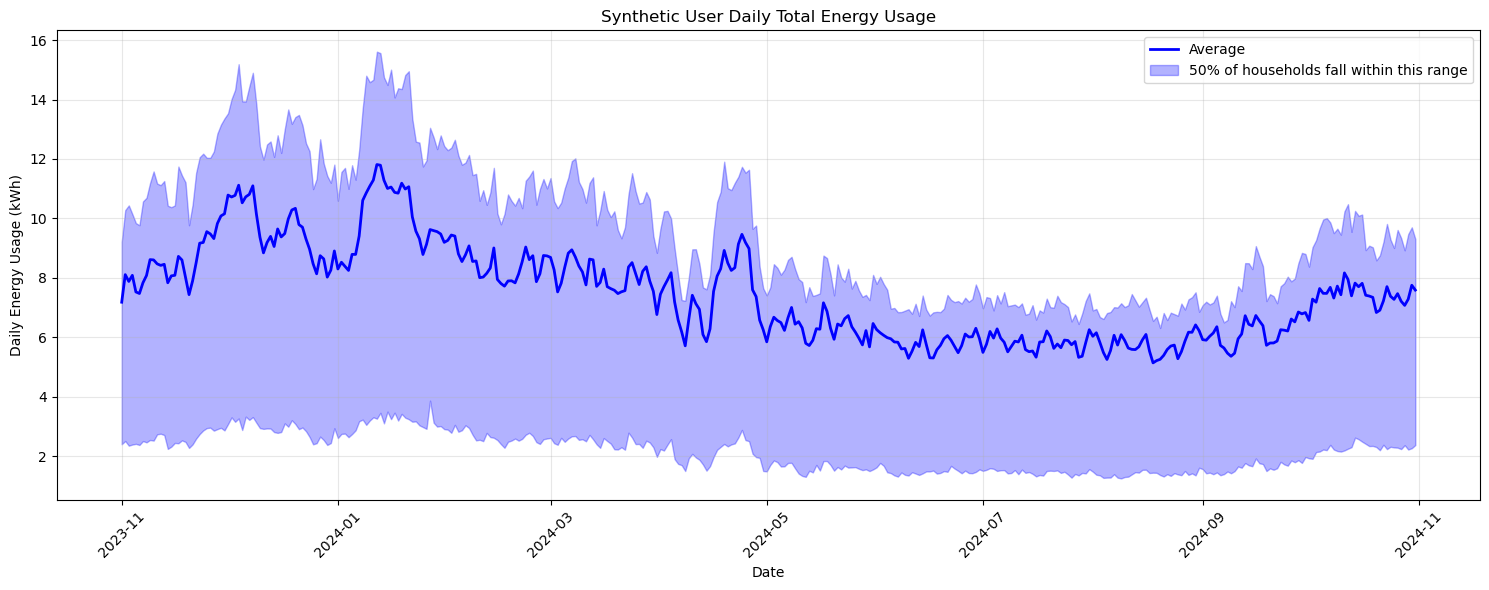

Chart shows 366 days of data
Average daily usage: 7.45 kWh/day


In [ ]:
import matplotlib.pyplot as plt

# Resample synthetic user data to daily totals (including confidence intervals)
daily_synthetic = synthetic_user.resample('D').sum()

# Create the chart with confidence intervals
plt.figure(figsize=(15, 6))
plt.plot(daily_synthetic.index, daily_synthetic['value'], linewidth=2, label='Average', color='blue')
plt.fill_between(daily_synthetic.index, 
                 daily_synthetic['ci_lower'], 
                 daily_synthetic['ci_upper'], 
                 alpha=0.3, color='blue', label='50% of households fall within this range')
plt.title('Synthetic User Daily Total Energy Usage')
plt.xlabel('Date')
plt.ylabel('Daily Energy Usage (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Chart shows {len(daily_synthetic)} days of data")
print(f"Average daily usage: {daily_synthetic['value'].mean():.2f} kWh/day")

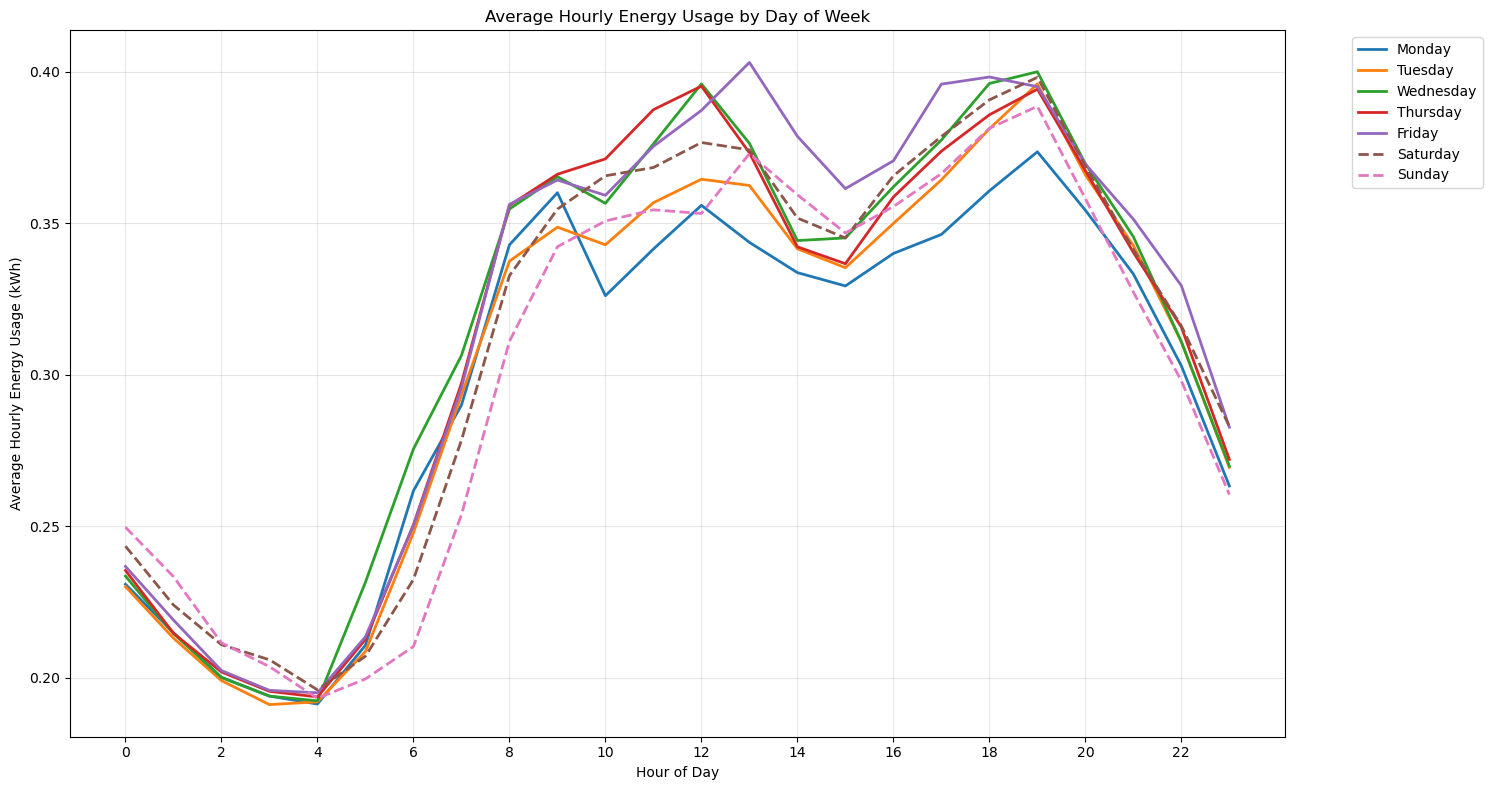

In [25]:
# Weekly energy usage pattern using hourly data
# Add day of week and hour info to hourly data
hourly_synthetic_weekly = synthetic_user.copy()
hourly_synthetic_weekly['day_of_week'] = hourly_synthetic_weekly.index.day_name()
hourly_synthetic_weekly['hour'] = hourly_synthetic_weekly.index.hour
hourly_synthetic_weekly['weekday'] = hourly_synthetic_weekly.index.weekday

# Calculate average usage by day of week and hour
weekly_hourly_pattern = hourly_synthetic_weekly.groupby(['day_of_week', 'hour'])['value'].mean().unstack(level=0)

# Reorder columns to start with Monday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_hourly_pattern = weekly_hourly_pattern.reindex(columns=day_order)

# Create the weekly hourly pattern chart
plt.figure(figsize=(15, 8))
for day in day_order:
    color = 'lightblue' if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'lightcoral'
    linestyle = '-' if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else '--'
    plt.plot(weekly_hourly_pattern.index, weekly_hourly_pattern[day], 
             label=day, linewidth=2, linestyle=linestyle)

plt.title('Average Hourly Energy Usage by Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Average Hourly Energy Usage (kWh)')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [36]:
# Average yearly energy usage by household size. Uses data from 2021 from destatis, as it is the most recent year with published data
one_person_average = 2105
two_person_average = 3470
three_person_average = 5411

# Calculate current total annual usage from synthetic user
current_daily_total = daily_synthetic['value'].sum()
days_in_data = len(daily_synthetic)
current_annual_usage = (current_daily_total / days_in_data) * 365

print(f"Current synthetic user annual usage: {current_annual_usage:.0f} kWh")

# Calculate scaling factors
scale_1_person = one_person_average / current_annual_usage
scale_2_person = two_person_average / current_annual_usage
scale_3_person = three_person_average / current_annual_usage

print(f"Scaling factors:")
print(f"1 person: {scale_1_person:.3f}")
print(f"2 person: {scale_2_person:.3f}")
print(f"3 person: {scale_3_person:.3f}")

# Create scaled dataframes with standard user data format
synthetic_1_person = pd.DataFrame()
synthetic_1_person['datetime'] = synthetic_user.index
synthetic_1_person['value'] = (synthetic_user['value'] * scale_1_person).values
synthetic_1_person = synthetic_1_person.reset_index(drop=True)

synthetic_2_person = pd.DataFrame()
synthetic_2_person['datetime'] = synthetic_user.index
synthetic_2_person['value'] = (synthetic_user['value'] * scale_2_person).values
synthetic_2_person = synthetic_2_person.reset_index(drop=True)

synthetic_3_person = pd.DataFrame()
synthetic_3_person['datetime'] = synthetic_user.index
synthetic_3_person['value'] = (synthetic_user['value'] * scale_3_person).values
synthetic_3_person = synthetic_3_person.reset_index(drop=True)

# Verify the annual totals
# For verification, we need to set datetime as index temporarily
temp_1 = synthetic_1_person.set_index('datetime')
temp_2 = synthetic_2_person.set_index('datetime')
temp_3 = synthetic_3_person.set_index('datetime')

daily_1_person = temp_1.resample('D').sum()
daily_2_person = temp_2.resample('D').sum()
daily_3_person = temp_3.resample('D').sum()

annual_1_person = (daily_1_person['value'].sum() / len(daily_1_person)) * 365
annual_2_person = (daily_2_person['value'].sum() / len(daily_2_person)) * 365
annual_3_person = (daily_3_person['value'].sum() / len(daily_3_person)) * 365

print(f"\nVerification - Annual usage:")
print(f"1 person household: {annual_1_person:.0f} kWh (target: {one_person_average})")
print(f"2 person household: {annual_2_person:.0f} kWh (target: {two_person_average})")
print(f"3 person household: {annual_3_person:.0f} kWh (target: {three_person_average})")

print(f"\nCreated scaled household DataFrames with same patterns but different usage levels")
print(f"\nDataFrame structure:")
print(f"1-person household: {synthetic_1_person.shape} - Columns: {list(synthetic_1_person.columns)}")
print(f"2-person household: {synthetic_2_person.shape} - Columns: {list(synthetic_2_person.columns)}")
print(f"3-person household: {synthetic_3_person.shape} - Columns: {list(synthetic_3_person.columns)}")

print(f"\nSample data (1-person household):")
display(synthetic_1_person.head())

Current synthetic user annual usage: 2720 kWh
Scaling factors:
1 person: 0.774
2 person: 1.276
3 person: 1.989

Verification - Annual usage:
1 person household: 2105 kWh (target: 2105)
2 person household: 3470 kWh (target: 3470)
3 person household: 5411 kWh (target: 5411)

Created scaled household DataFrames with same patterns but different usage levels

DataFrame structure:
1-person household: (8784, 2) - Columns: ['datetime', 'value']
2-person household: (8784, 2) - Columns: ['datetime', 'value']
3-person household: (8784, 2) - Columns: ['datetime', 'value']

Sample data (1-person household):


,datetime,value
0,2023-11-01 00:00:00,0.132947
1,2023-11-01 01:00:00,0.170096
2,2023-11-01 02:00:00,0.177509
3,2023-11-01 03:00:00,0.163329
4,2023-11-01 04:00:00,0.149790


In [37]:
# Save synthetic household DataFrames as CSV files
import os

# Define the path to household_data folder
household_data_path = "../../../../data/household_data/"

# Create the directory if it doesn't exist (though it should already exist)
os.makedirs(household_data_path, exist_ok=True)

# Save each synthetic household DataFrame
synthetic_1_person.to_csv(os.path.join(household_data_path, "synthetic_1_person_household.csv"), index=False)
synthetic_2_person.to_csv(os.path.join(household_data_path, "synthetic_2_person_household.csv"), index=False)
synthetic_3_person.to_csv(os.path.join(household_data_path, "synthetic_3_person_household.csv"), index=False)